# Kelompok 37 Extractive Question-Answering bahasa indonesia 
nama kelompok : <br>
Rizky Dwi Saputra (19090107)<br>
Moh Saefudin Fikri (19090101)

dataset : https://drive.google.com/file/d/145G-LBqjcgNfFeFw3t0WqbljW4ynF8a9/view dari https://github.com/Wikidepia/SQuAD-id/blob/master/data/train-SQuAD-id.json 



# setup

In [ ]:
! pip install transformers # transformers library from huggingface
! pip install datasets # datasets library from huggingface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import json
import torch
import numpy as np

from transformers import BertTokenizerFast, BertForQuestionAnswering, Trainer, TrainingArguments 

device = "cuda" if torch.cuda.is_available() else "cpu" 
torch.device(device) 

device(type='cuda')

# download dataset

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Source: https://github.com/Wikidepia/indonesian_datasets/tree/master/question-answering/squad, in download dataset https://cloud.depia.wiki/squad/tar/.
#! wget https://cloud.depia.wiki/squad/tar/train-v2.0.json 
#! wget https://cloud.depia.wiki/squad/tar/dev-v2.0.json 

# SQuAD2.0 doesn't provide test set. 

In [ ]:
# Showing some examples
#f = open("train-v2.0.json")
f = open("/content/drive/MyDrive/smt6/Bigprojects2/Data/train-v2.0.json")
jsonObj = json.load(f)
f.close

print("Root Keys:", jsonObj.keys())
print("Data Lenght:", len(jsonObj["data"]))
print("Keys:", jsonObj["data"][0].keys())
print("Title:", jsonObj["data"][0]["title"])
print("Data Lenght:", len(jsonObj["data"][0]["paragraphs"]))
print("Keys:", jsonObj["data"][0]["paragraphs"][0].keys())
print("Context:", jsonObj["data"][0]["paragraphs"][0]["context"])
print("Data Lenght:", len(jsonObj["data"][0]["paragraphs"][0]["qas"]))
print("Keys:", jsonObj["data"][0]["paragraphs"][0]["qas"][0].keys())
print("Question:", jsonObj["data"][0]["paragraphs"][0]["qas"][0]["question"])
print("Data Lenght:", len(jsonObj["data"][0]["paragraphs"][0]["qas"][0]["answers"]))
print("Answer:", jsonObj["data"][0]["paragraphs"][0]["qas"][0]["answers"][0])
print("Is Impossible:", jsonObj["data"][0]["paragraphs"][0]["qas"][0]["is_impossible"])
jsonObj = None # Free the Memory.

Root Keys: dict_keys(['version', 'data'])
Data Lenght: 442
Keys: dict_keys(['title', 'paragraphs'])
Title: Beyoncé
Data Lenght: 66
Keys: dict_keys(['context', 'qas'])
Context: Beyoncé Giselle Knowles-Carter (/bijanse / bee-YON-say) (lah lahir 4 September 1981) adalah penyanyi Amerika, penulis lagu, produser rekaman dan aktris. Lahir dan dibesarkan di Houston, Texas, dia tampil dalam berbagai kompetisi menyanyi dan menari sebagai seorang anak, dan menjadi terkenal pada akhir 1990-an sebagai penyanyi utama dari R&B gadis-grup Destiny's Child. Dikelola oleh ayahnya, Mathew Knowles, kelompok itu menjadi salah satu kelompok gadis terlaris di dunia sepanjang masa. Hiatus mereka melihat rilis album debut Beyonce, Berbahaya dalam Cinta (2003), yang didirikan sebagai artis solo di seluruh dunia, memperoleh lima Grammy Awards dan menampilkan Billboard Hot 100 nomor satu "Gila Cinta" dan "Baby Boy."
Data Lenght: 15
Keys: dict_keys(['question', 'answers', 'id', 'is_impossible'])
Question: Kapan Be

# load model

In [ ]:
modelCheckpoint = "indolem/indobert-base-uncased"

# memilih modelcheckpoint

In [ ]:
class MyQuestionAnsweringDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, index):
    item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    return item

  def __len__(self):
    return len(self.encodings["input_ids"])

# searchanswer postion

In [ ]:
def searchAnswerPosition(encodings, answers):
  offsetMapping = encodings.pop("offset_mapping")
  startPositions = []
  endPositions = []

  for i, offset in enumerate(offsetMapping): # offset_mapping contains tupples of (char_start, char_end) for each token.
    sequenceIds = encodings.sequence_ids(i)

    contextStartIndex = 0
    while sequenceIds[contextStartIndex] != 1:
      contextStartIndex += 1
    
    contextEndIndex = contextStartIndex
    while sequenceIds[contextEndIndex] == 1:
      contextEndIndex += 1
    contextEndIndex -= 1 # Minus 1!

    answer = answers[i]
    startCharIndex = answer["answer_start"]
    endCharIndex = startCharIndex + len(answer["text"])
    
    if offset[contextStartIndex][0] > endCharIndex or offset[contextEndIndex][1] < startCharIndex: # If the answer is not inside the context.
      # label it (0, 0)
      startPositions.append(0)
      endPositions.append(0)
    else: # If the answer is inside the context.
      # BEGIN: Searching the index of starting token of the answer from left to right in the context.
      index = contextStartIndex
      while index <= contextEndIndex and offset[index][0] <= startCharIndex:
        index += 1
      startPositions.append(index - 1)
      # END: Searching the index of starting token of the answer from left to right in the context.

      # BEGIN: Searching the index of ending token of the answer from right to left in the context.
      index = contextEndIndex
      while index >= contextStartIndex and offset[index][1] >= endCharIndex:
        index -= 1
      endPositions.append(index + 1)
      # END: Searching the index of ending token of the answer from right to left in the context.

  return startPositions, endPositions

# checkanswerindex

In [ ]:
def checkAnswerIndex(context, answer):
  answerStart = answer["answer_start"]
  answerText = answer["text"]
  answerLen = len(answerText)
  if context[answerStart:answerStart+answerLen] != answerText:
    print("ERROR: Answer index doens't match!", answerStart)

def preprocess(jsonObj):
  data = []
  for item in jsonObj["data"]:
    for paragraph in item["paragraphs"]:
      context = paragraph["context"]
      for qa in paragraph["qas"]:
        if qa["is_impossible"]: # If no answer.
          # answer = {'text': '', 'answer_start': 0}
          continue  # Because we have computation limitation, let's ignore the impossible questions for now.
        else:
          answer = qa["answers"][0] # Take only the first version of answer.
          if answer["answer_start"] + len(answer["text"]) > 1000:
            continue  # Because we have computation limitation, let's ignore this data for now.
        
        question = qa["question"]
        data.append({"context": context, "question": question, "answer": answer})
        checkAnswerIndex(context, answer)

  return data

# myquestionanswering dataset

In [ ]:
# BEGIN: Load json file.
f = open("/content/drive/MyDrive/smt6/Bigprojects2/Data/train-v2.0.json")
trainJsonObj = json.load(f)
f.close

f = open("/content/drive/MyDrive/smt6/Bigprojects2/Data/dev-v2.0.json")
valJsonObj = json.load(f)
f.close
f = None # Free the RAM.
# END: Load json file.
# menambahkan Testing data dari 
# dataset yang sama dari validasi
f = open("/content/drive/MyDrive/smt6/Bigprojects2/Data/dev-v2.0.json")
testJsonObj = json.load(f)
f.close
f = None # Free the RAM.
# END: Load json file.

# BEGIN: Preprocess.
trainData = preprocess(trainJsonObj)
trainJsonObj = None # Free the RAM.
valData = preprocess(valJsonObj)
valJsonObj = None # Free the RAM.
testData = preprocess(testJsonObj)
testJsonObj = None # Free the RAM.
# END: Preprocess.

# BEGIN: Shuffle and take a subset.
random.shuffle(trainData) # Shuffle the data.
random.shuffle(valData) # Shuffle the data.
trainData = trainData[:7500] # Take only 5.000 data or how many you want. Higher is slower.
valData = valData[:2500] # Take only 5.000 data or how many you want. Higher is slower.
testData = testData[:2500] # untuk testing dan validasi kami ambil sama yaitu 2500 
# END: Shuffle and take a subset.

print("Training:", len(trainData), "data")
print("Validation:", len(valData), "data")
print("Testing:", len(testData), "data")
print()
print(trainData[0])
print()

# BEGIN: Encode Training Data.
trainQuestions = []
trainContexts = []
trainAnswers = []
for item in trainData:
  trainQuestions.append(item["question"])
  trainContexts.append(item["context"])
  trainAnswers.append(item["answer"])

trainData = None # Free the RAM.

tokenizer = BertTokenizerFast.from_pretrained(modelCheckpoint) # Re-init the tokenizer to free the RAM.
trainEncodings = None # Empty big-valued variable if it has been used before. Free the RAM.
trainEncodings = tokenizer(trainQuestions, trainContexts, padding=True, return_offsets_mapping=True, truncation="only_second", max_length=250)
trainQuestions = None # Free the RAM.
trainContexts = None # Free the RAM.
tokenizer = None # Free the RAM.
# END: Encode Training Data.

# BEGIN: Encode Validation Data.
valQuestions = []
valContexts = []
valAnswers = []
for item in valData:
  valQuestions.append(item["question"])
  valContexts.append(item["context"])
  valAnswers.append(item["answer"])

valData = None # Free the RAM.

tokenizer = BertTokenizerFast.from_pretrained(modelCheckpoint) # Re-init the tokenizer to free the RAM.
valEncodings = None # Empty big-valued variable if it has been used before. Free the RAM.
valEncodings = tokenizer(valQuestions, valContexts, padding=True, return_offsets_mapping=True, truncation="only_second", max_length=250)
valQuestions = None # Free the RAM.
valContexts = None # Free the RAM.
tokenizer = None # Free the RAM.
# END: Encode Validation Data.
# BEGIN: Encode testing Data.
testQuestions = []
testContexts = []
testAnswers = []
for item in testData:
  testQuestions.append(item["question"])
  testContexts.append(item["context"])
  testAnswers.append(item["answer"])

testData = None # Free the RAM.

tokenizer = BertTokenizerFast.from_pretrained(modelCheckpoint) # Re-init the tokenizer to free the RAM.
testEncodings = None # Empty big-valued variable if it has been used before. Free the RAM.
testEncodings = tokenizer(testQuestions, testContexts, padding=True, return_offsets_mapping=True, truncation="only_second", max_length=250)
testQuestions = None # Free the RAM.
testContexts = None # Free the RAM.
tokenizer = None # Free the RAM.
# END: Encode testing Data.

# BEGIN: Searching for answer position in encoding.
trainEncodings["start_positions"], trainEncodings["end_positions"] = searchAnswerPosition(trainEncodings, trainAnswers)
valEncodings["start_positions"], valEncodings["end_positions"] = searchAnswerPosition(valEncodings, valAnswers)
testEncodings["start_positions"], testEncodings["end_positions"] = searchAnswerPosition(testEncodings, testAnswers)
# END: Searching for answer position in encoding.

trainDataset = MyQuestionAnsweringDataset(trainEncodings)
valDataset = MyQuestionAnsweringDataset(valEncodings)
testDataset = MyQuestionAnsweringDataset(testEncodings)

Training: 7500 data
Validation: 2500 data
Testing: 2500 data

{'context': 'Bahasa kesusastraan modern biasanya dianggap berasal dari zaman Aleksander Pushkin (Negara yang pertama pada abad ke - 19. Pushkin merevolusi literatur Rusia dengan menolak tata bahasa dan kosa kata kuno (yang disebut sebagai "OUBYсксксктск стк" å "gaya tinggi") yang mendukung tata bahasa dan kosa kata yang digunakan dalam bahasa zaman itu. Bahkan, para pembaca modern yang lebih muda mungkin hanya mengalami sedikit kesulitan untuk memahami beberapa kata dalam ayat - ayat Pushkin, karena hampir sedikit kata yang digunakan Pushkin telah menjadi kuno atau berubah maknanya. Bahkan, banyak ungkapan yang digunakan oleh para penulis Rusia pada awal abad ke-19, khususnya Pushkin, Mikhail Lermontov (eekspresi yang digunakan oleh para penulis Rusia pada awal abad ke-19, atau khususnya Pushkin), Aleksander Griboyedov (racictic ноооотовотов), menjadi peribahasa atau pepatahan yang sering ditemukan dalam bahasa Inggris moder

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

# load model

In [ ]:
# Loading the model.
model = BertForQuestionAnswering.from_pretrained(modelCheckpoint)
model.to(device) # Send to GPU if available.
# Send to GPU if available.
print() 

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at indolem/indobert-base-uncased and a

# model arsitektur

In [ ]:
# Print the architecture
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

# training

In [ ]:
# https://huggingface.co/docs/transformers/master/en/main_classes/trainer#transformers.TrainingArguments
from transformers import AdamW
from transformers.optimization import Adafactor, AdafactorSchedule

trainingArgs = TrainingArguments(
  output_dir = "/content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint",
  evaluation_strategy = "epoch",
  logging_strategy = "epoch",
  save_strategy = "epoch",
  overwrite_output_dir = True,
  per_device_train_batch_size = 16, # 16 or 32 is recommended.
  per_device_eval_batch_size = 1,
  learning_rate = 5e-5, # 5e-5, 2e-5, or 1e-5 is recommended.
  weight_decay = 0.01, # 0, 0.01, 0.05, 0.1, 0.15, or 0.2.
  num_train_epochs = 10,
  logging_steps = 1, # To print training loss in each epoch.
  load_best_model_at_end = True,
  metric_for_best_model = "em",
  greater_is_better = True,
  
)
def computeMetrics(evalPreds):
  (startPredictions, endPredictions), (startLabels, endLabels) = evalPreds
  startPredictions = np.argmax(startPredictions, axis=1)
  endPredictions = np.argmax(endPredictions, axis=1)
  optimizer = Adafactor(model.parameters())
  
  em = 0
  f1 = 0
  for startPrediction, endPrediction, startLabel, endLabel in zip(startPredictions, endPredictions, startLabels, endLabels):
    if startPrediction == startLabel and endPrediction == endLabel:
      em += 1
    
    min = np.min([startPrediction, startLabel])
    startPrediction -= min
    startLabel -= min
    endPrediction -= min
    endLabel -= min
    min = 0
    max = np.max([endPrediction, endLabel])
    
    prediction = []
    label = []
    for i in range(min, max):
      if startLabel <= i and i <= endLabel:
        label.append(1)
      else:
        label.append(0)
      
      if startPrediction <= i and i <= endPrediction:
        prediction.append(1)
      else:
        prediction.append(0)

    falsePositive = 1e-8
    falseNegative = 1e-8
    truePositive = 1e-8
    for iPred, iLabel in zip(prediction, label):
      if iPred > iLabel: # if iPred == 1 and iLabel == 0
        falsePositive += 1
      elif iPred < iLabel: # if iPred == 0 and iLabel == 1
        falseNegative += 1
      else: # if iPred == iLabel
        truePositive += 1

    precision = truePositive / (truePositive + falsePositive)
    recall = truePositive / (truePositive + falseNegative)
    f1 += 2 * precision * recall / (precision + recall)

  em = em/len(startPredictions) # exact match
  f1 = f1/len(startPredictions) #f1 skore training dan f1 skore validasi
 
  return {"em": em, "f1": f1}

# https://huggingface.co/docs/transformers/master/en/main_classes/trainer
trainer = Trainer(
  model = model,
  args = trainingArgs,
  train_dataset = trainDataset,
  eval_dataset = valDataset,
  compute_metrics = computeMetrics,
  # The default optimizer used by the trainer is AdamW. So, no need to specify.
  # If you want to change the optimizer, please read https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.optimizers .
)
trainer.train()
#error di forward https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForQuestionAnswering.forward

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7500
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4690


Epoch,Training Loss,Validation Loss,Em,F1
1,2.528200,1.935400,0.390000,0.717473
2,1.442600,1.924960,0.404400,0.721659
3,0.886300,2.225489,0.395200,0.722326
4,0.531700,2.536591,0.379600,0.713372
5,0.311700,2.773070,0.378800,0.704930
6,0.189900,3.345154,0.390400,0.710117
7,0.113400,3.933338,0.387600,0.707195
8,0.074900,4.092632,0.386800,0.691596
9,0.048700,4.322326,0.379600,0.695446
10,0.029800,4.471731,0.386400,0.694057


***** Running Evaluation *****
  Num examples = 2500
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-469
Configuration saved in /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-469/config.json
Model weights saved in /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-469/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-938
Configuration saved in /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-938/config.json
Model weights saved in /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-938/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-1407
Configuration saved in /content/drive/MyDrive

TrainOutput(global_step=4690, training_loss=0.6157255010055834, metrics={'train_runtime': 3864.9655, 'train_samples_per_second': 19.405, 'train_steps_per_second': 1.213, 'total_flos': 9568973025000000.0, 'train_loss': 0.6157255010055834, 'epoch': 10.0})

# Graph

NameError: ignored

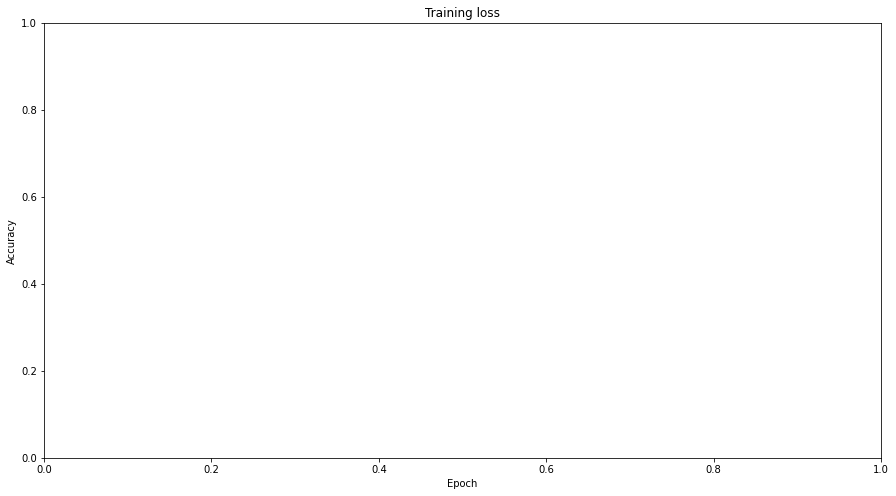

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(epoch)
plt.show()

# contoh

In [ ]:
context = """Pangeran Harya Dipanegara (atau biasa dikenal dengan nama Pangeran Diponegoro, lahir di Ngayogyakarta Hadiningrat, 11 November 1785 – meninggal di Makassar, Hindia Belanda, 8 Januari 1855 pada umur 69 tahun) adalah salah seorang pahlawan nasional Republik Indonesia,
yang memimpin Perang Diponegoro atau Perang Jawa selama periode tahun 1825 hingga 1830 melawan pemerintah Hindia Belanda. 
Sejarah mencatat, Perang Diponegoro atau Perang Jawa dikenal sebagai perang yang menelan korban terbanyak dalam sejarah Indonesia, yakni 8.000 korban serdadu Hindia Belanda, 7.000 pribumi, dan 200 ribu orang Jawa serta kerugian materi 25 juta Gulden."""
from transformers import BertTokenizerFast, BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained("/content/drive/MyDrive/smt6/Bigprojects2/model_checkpoint/checkpoint-938")
tokenizer = BertTokenizerFast.from_pretrained(modelCheckpoint)
question = "kapan pangeran diponegoro lahir?"
encidedData=[]

encodedData = tokenizer(question, context, padding=True, return_offsets_mapping=True, truncation="only_second", return_tensors="pt")
offsetMapping = encodedData.pop("offset_mapping")[0]
encodedData.to(device)
model.to(device)

model.eval() # IMPORTANT! Set the model as evaluation mode.
with torch.no_grad(): # IMPORTANT! Do not computing gradient!
  outputs = model(encodedData["input_ids"], attention_mask=encodedData["attention_mask"]) # Feed forward. Without calculating loss.

startLogits = outputs.start_logits[0].detach().cpu().numpy() # Getting logits, moving to CPU.
endLogits = outputs.end_logits[0].detach().cpu().numpy() # Getting logits, moving to CPU.

start_indexes = np.argsort(startLogits).tolist()
end_indexes = np.argsort(endLogits).tolist()
candidates = []
for start_index in start_indexes:
  for end_index in end_indexes:
    if (
      start_index >= len(offsetMapping)
      or end_index >= len(offsetMapping)
      or offsetMapping[start_index] is None
      or offsetMapping[end_index] is None
    ):
      continue
    
    if end_index < start_index or end_index - start_index + 1 > 25:
      continue

    if start_index <= end_index:
      start_char = offsetMapping[start_index][0]
      end_char = offsetMapping[end_index][1]
      candidates.append({
        "score": startLogits[start_index] + endLogits[end_index],
        "text": context[start_char: end_char]
      })

candidates = sorted(candidates, key=lambda x: x["score"], reverse=True)[:3]

# to do list 
# testing dengan datatesting skorenya berapa
# 
print(context)
print(question)
print("Rank", "|", "Answer Candidate")
for i, candiate in enumerate(candidates):
  print(i+1, "|", candidate["text"])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Pangeran Harya Dipanegara (atau biasa dikenal dengan nama Pangeran Diponegoro, lahir di Ngayogyakarta Hadiningrat, 11 November 1785 – meninggal di Makassar, Hindia Belanda, 8 Januari 1855 pada umur 69 tahun) adalah salah seorang pahlawan nasional Republik Indonesia,
yang memimpin Perang Diponegoro atau Perang Jawa selama periode tahun 1825 hingga 1830 melawan pemerintah Hindia Belanda. 
Sejarah mencatat, Perang Diponegoro atau Perang Jawa dikenal sebagai perang yang menelan korban terbanyak dalam sejarah Indonesia, yakni 8.000 korban serdadu Hindia Belanda, 7.000 pribumi, dan 200 ribu orang Jawa serta kerugian materi 25 juta Gulden.
kapan pangeran diponegoro lahir?
Rank | Answer Candidate
1 | 11 November 1785
2 | 1785
3 | 11 November 1785 – meninggal di Makassar, Hindia Belanda, 8 Januari 1855


# save model

In [ ]:
import torch
torch.save(model, 'coba.bin')

saved_model = torch.load('coba.bin')

NameError: ignored

# convert model .h5

In [ ]:
output_model = 'bigproject.h5'
optimizer = model.parameters()
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
    }, output_model)

save(model, optimizer)

# load
checkpoint = torch.load(output_model, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

NameError: ignored